In [1]:
#importing all the required libraries
import pandas as pd
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score


In [2]:
#importing the original training data
df = pd.read_csv(r'C:\Users\dsh\Downloads\cs529-project-2-nb\training.csv')

In [3]:
#Splitting the data into training and testing data in the ratio 80:20
training_data, testing_data = train_test_split(df, test_size = .2, random_state = 42)

#List of all the class labels for training data
class_labels = training_data[training_data.columns[-1]].unique()

#total number of different words in the dataset
total_words = training_data.shape[1] -2 

#total number of classes
total_classes = len(class_labels)


In [4]:
# Lists of learning_rate and penalty_terms for tuning logistic regression.
list_lr = [.001, .0025, .0050, .0075, .01, .1]
list_p = [.001, .0025, .0050, .0075, .01, .1]


updates = 100 # Number of weight updates in logistic regression
lr = .01 # Learning or eta term
pr = .005 # Penalty rate

In [14]:
#function to train_weights
def training_weights(training_data, lr, pr):
    
    #variable to store number of rows
    rows = training_data.shape[0] 

    #storing the actual classes of the training data
    actual_classes = list(training_data[training_data.columns[-1]]) 

    #creating a zero matrix
    delta_mtrx= np.zeros((total_classes, rows))

    count = 0
    for cls in actual_classes:
        # for class label on the count, set index = 1
        delta_mtrx[cls-1, count] = 1
        count += 1

    #sparse matrix
    delta_mtrx = scipy.sparse.csr_matrix(delta_mtrx) 

    #dropping the index and class columns
    training_data = training_data.drop('1', axis=1)
    training_data = training_data.drop('14', axis=1)
    
    #creating sparse with training data
    reshaped_data = scipy.sparse.csr_matrix(training_data)
    
    #normalising the reshaped_data
    add_c = np.array(reshaped_data.sum(axis=0))[0,:]
    add_c[add_c==0]=1
    reshaped_data /= add_c

    #creating a weights matrix
    weights = scipy.sparse.csr_matrix(np.zeros((total_classes, total_words), dtype=np.float64))
    
    for i in range(updates):
        
        # matrix of probabilities, P( Y | W, X) ~ exp(W * X^T)
        Z_term = np.expm1(weights.dot(reshaped_data.transpose()))
        
        #normalize Z
        add_c = np.array(Z_term.sum(axis=0))[0,:] # column vector
        add_c[add_c==0]=1
        Z_term /= add_c
        
        # = Z / Z.sum(axis=0)
        # gradient w.r.t. Weights with regularization
        gradient = ((delta_mtrx - Z_term) * reshaped_data) - (pr * weights)
        
        # learning rule
        weights = weights + (lr * gradient)
        
    return weights

In [16]:
#function to test the accuracy on testing data
def validation(testing_data, lr, pr):
    
    #calling the train_weights function to store weights
    train_weights = training_weights(training_data, lr, pr)

    test_classes = list(testing_data[testing_data.columns[-1]])
    testing_data_copy = testing_data.copy()

    testing_data = testing_data.drop('1', axis=1)
    testing_data = testing_data.drop('14', axis=1)

    predicted_values = np.expm1(train_weights.dot(testing_data.transpose()))
    
    # take maximum and get index for every example
    maximum_index = predicted_values.argmax(axis=0).ravel().tolist()
    result = []
    for i in range(predicted_values.shape[1]):
        result.append(maximum_index[0][i] + 1)

    values_pred = result
    predictions_array = np.array(values_pred)
    actual_classes = np.array(testing_data_copy.iloc[:,-1])

    #gives the accuracy for this validation
    accuracy = accuracy_score(actual_classes, predictions_array)
    
    #returns the accuracy
    return accuracy

In [17]:
#calling the validation function to report testing accuracy
training_accuracy = validation(testing_data, lr, pr)
print(training_accuracy)

0.8504166666666667


In [18]:
#function to test the actual testing data
def testing(actual_testing_data, lr, pr):
    actual_testing_copy = actual_testing_data.drop(0, axis=1)

    #calling the train_weights function to store weights
    train_weights = training_weights(training_data, lr, pr)
    
    predicted = np.expm1(train_weights.dot(actual_testing_copy.transpose()))
    
    # take maximum and get index for every example
    maximum_index = predicted.argmax(axis=0).ravel().tolist()
    
    #list to store the classes of testing data
    result = []
    result.append(['id','class'])
    
    for i in range(predicted.shape[1]):
        result.append([i+12001 ,maximum_index[0][i] + 1])
        
    #returns the list of ids and classes
    return result

In [19]:
#importing the actual testing data
actual_testing_data = pd.read_csv(r'C:\Users\dsh\Downloads\cs529-project-2-nb\testing.csv', header=None)

In [20]:
final_predictions = testing(actual_testing_data, lr, pr)

# Saving the predictions to the csv file
result_frame = pd.DataFrame(final_predictions)
result_frame.to_csv("predicted_lr.csv", header=None, index=None)

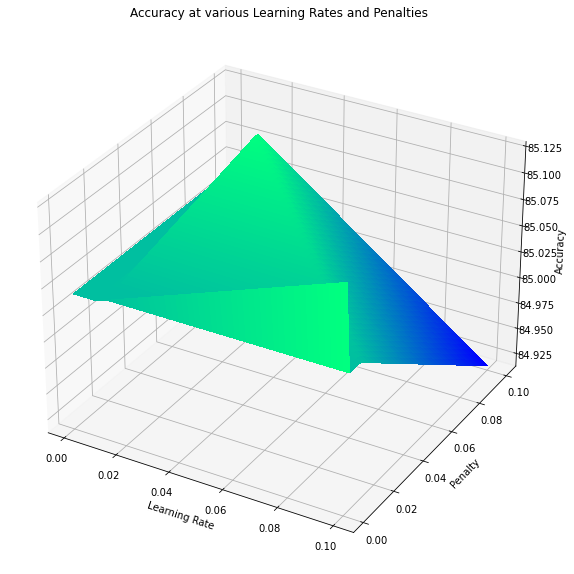

In [21]:
#list to store accuracies for different lr and pr values
accuracies = []

#list to store the lr values for x axis
x_ax = []

#list to store the pr values for y axis
y_ax = []

for lr in list_lr:
    for pr in list_p:
        training_accuracy = validation(testing_data, lr, pr)
        accuracies.append(training_accuracy)
        
        x_ax.append(lr)
        y_ax.append(pr)
        #print ( lr, pr, training_accuracy)
#print(accuracies)  

#assigning 3 lists to 3 coordinates of the graph
x_coords = np.array(x_ax)
y_coords = np.array(y_ax)
z_coords = np.array(accuracies)
z_coords = z_coords * 100

# Plot a figure and set it to 3d.
fig = plt.figure(figsize=(10,10))

# Set the projection to 3d
ax = plt.axes(projection="3d")

# Set the labels for each axis.
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Penalty')
ax.set_zlabel('Accuracy')

# Get the boundaries for x and y axis.
x_bounds = np.linspace(min(x_coords), max(x_coords))
y_bounds = np.linspace(min(y_coords), max(y_coords))

# Get the Z co-ordinates using griddate and plot the surface.
X, Y = np.meshgrid(x_bounds, y_bounds)
Z = griddata((x_coords, y_coords), z_coords, (X, Y), method='linear')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='winter',antialiased=False, edgecolor='none')

# Set the title for the  graph.
ax.set_title('Accuracy at various Learning Rates and Penalties')

# Show the plot.
plt.show()

In [22]:
#function to create a confusion matrix
def conf_matrix(testing_data, lr, pr):
    
    #calling the train_weights function to store weights
    train_weights = training_weights(training_data, lr, pr)

    test_classes = list(testing_data[testing_data.columns[-1]])
    testing_data_copy = testing_data.copy()

    testing_data = testing_data.drop('1', axis=1)
    testing_data = testing_data.drop('14', axis=1)

    predicted_values = np.expm1(train_weights.dot(testing_data.transpose()))
    
    # take maximum and get index for every example
    maximum_index = predicted_values.argmax(axis=0).ravel().tolist()
    result = []
    for i in range(predicted_values.shape[1]):
        result.append(maximum_index[0][i] + 1)

    values_pred = result
    predictions_array = np.array(values_pred)
    actual_classes = np.array(testing_data_copy.iloc[:,-1])
    
    #drawing the confusion matrix for fixed lr,pr values.
    print(confusion_matrix(actual_classes,predictions_array))

conf_matrix(testing_data, lr, pr)

[[ 86   0   0   0   0   0   0   0   0   0   0   0   0   0   0  13   0   4
    1   5]
 [  1 119   4   5   1   3   0   0   0   0   0   3   0   0   2   0   0   0
    0   0]
 [  1  10  96  11   3   9   1   0   0   0   1   0   0   0   0   1   0   0
    0   0]
 [  0   3   5 105   7   0   2   0   0   0   0   1   3   0   0   5   0   2
    0   0]
 [  0   1   1   3  91   0   0   1   0   0   0   4   0   0   1   5   0   3
    0   0]
 [  0   6   3   1   1 101   0   0   0   0   0   2   0   0   0   2   0   1
    0   0]
 [  0   0   2   7   3   0  78   7   0   0   1   1   3   2   0   5   0   2
    0   0]
 [  0   1   0   0   1   1   1  96   1   0   0   3   0   0   0   1   0   4
    0   0]
 [  0   0   0   0   0   0   2   4 143   0   0   0   0   0   0   1   0   1
    0   0]
 [  0   0   0   0   0   0   0   0   0 139   1   0   0   0   0   2   0   0
    2   0]
 [  0   0   0   0   0   0   0   0   0   0 128   1   0   0   0   0   0   0
    0   0]
 [  0   2   0   0   0   1   1   0   0   0   0 123   0   0   0   0